In [0]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_path = '/content/drive/My Drive/chest_xray/train'
val_path = '/content/drive/My Drive/chest_xray/val'
test_path = '/content/drive/My Drive/chest_xray/test'

In [0]:
target_size = (224,224)
colormode = 'rgb'
seed = 666
batch_size = 64

# Training ImageDataGenerator will have data augumentation parameters.
train_datagen1 = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)


train_generator1 = train_datagen1.flow_from_directory(directory = train_path, 
                                             target_size = target_size, 
                                             color_mode = colormode, 
                                             batch_size = batch_size,
                                             class_mode = 'binary',
                                             shuffle = True,
                                             seed = seed)

train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                             target_size = target_size, 
                                             color_mode = colormode, 
                                             batch_size = batch_size,
                                             class_mode = 'binary',
                                             shuffle = True,
                                             seed = seed)


test_generator = test_datagen.flow_from_directory(directory = test_path,
                                            target_size = target_size,
                                            color_mode = colormode,
                                            batch_size = batch_size ,
                                            class_mode = 'binary',
                                            shuffle = False, 
                                            seed = seed)

valid_generator = val_datagen.flow_from_directory(directory = val_path,
                                             target_size = target_size,
                                             color_mode = colormode,
                                             batch_size = batch_size,
                                             class_mode = 'binary',
                                             shuffle = True,
                                             seed = seed)


Found 5239 images belonging to 2 classes.
Found 5239 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
sample_training_images, label= next(train_generator1) 

In [0]:
img= np.array([sample_training_images[15]])
img.shape


(1, 224, 224, 3)

In [0]:
label.shape

(64,)

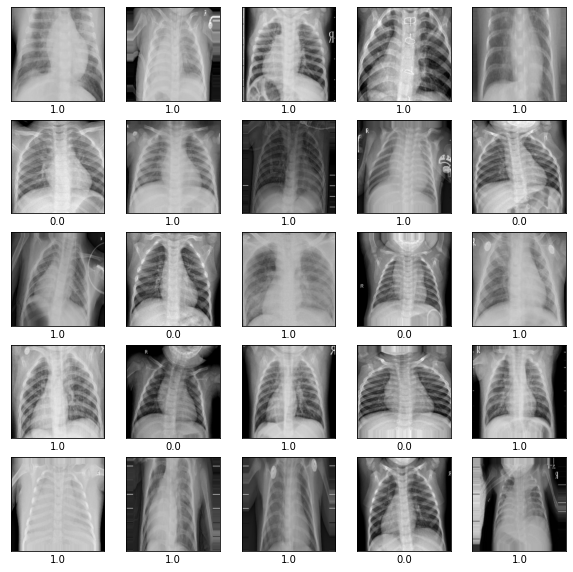

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_training_images[i]), #cmap=plt.cm.binary)
    plt.xlabel(label[i])
plt.show()

In [0]:
# Define number of steps for fit_generator function
STEP_SIZE_TRAIN = 32
STEP_SIZE_VALID = 32
STEP_SIZE_TEST = 32

In [0]:
"""base_model = keras.applications.VGG16(include_top=False, weights='imagenet',input_shape = (224,224,3))
x = keras.layers.Flatten() (base_model.output)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.Dropout(0.4)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.models.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])
"""

58892288/58889256 [==============================] - 0s 0us/step


In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [0]:
base_model = InceptionV3(include_top=False, weights='imagenet',input_shape = (224,224,3))
x = keras.layers.Flatten() (base_model.output)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.25)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.models.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [0]:

#checkpoint = ModelCheckpoint('/content/drive/My Drive/best_model.hdf5', verbose = 1, monitor = 'val_binary_accuracy', save_best_only = True)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=2)

In [0]:
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = test_generator,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = 5, callbacks = [callback])
#callbacks = [checkpoint]

Epoch 1/8
32/32 [==============================] - 768s 24s/step - loss: 0.9227 - binary_accuracy: 0.7082 - val_loss: 0.4806 - val_binary_accuracy: 0.7500
Epoch 2/8
32/32 [==============================] - 48s 1s/step - loss: 0.5013 - binary_accuracy: 0.8052 - val_loss: 0.3745 - val_binary_accuracy: 0.9375
Epoch 3/8
32/32 [==============================] - 49s 2s/step - loss: 0.4213 - binary_accuracy: 0.8311 - val_loss: 0.4105 - val_binary_accuracy: 0.8750
Epoch 4/8
32/32 [==============================] - 48s 1s/step - loss: 0.3058 - binary_accuracy: 0.8700 - val_loss: 0.3597 - val_binary_accuracy: 0.8750
Epoch 5/8
32/32 [==============================] - 48s 2s/step - loss: 0.3013 - binary_accuracy: 0.8813 - val_loss: 0.4052 - val_binary_accuracy: 0.8125
Epoch 6/8
32/32 [==============================] - 48s 2s/step - loss: 0.3014 - binary_accuracy: 0.8676 - val_loss: 0.3809 - val_binary_accuracy: 0.8125
Epoch 7/8
32/32 [==============================] - 48s 2s/step - loss: 0.2975 - 


**Visualize Accuracy and loss as training progresses.**

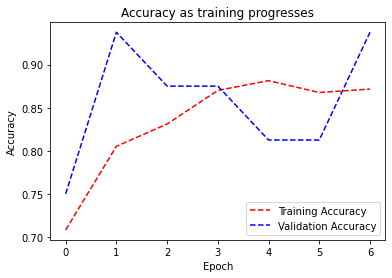

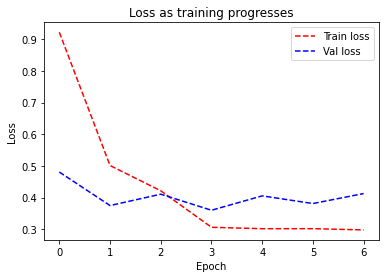

In [0]:
fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy as training progresses')
plt.plot(history.history['binary_accuracy'],'r--', label = "Training Accuracy" , linewidth=1.5)
plt.plot(history.history['val_binary_accuracy'], 'b--', label = "Validation Accuracy",  linewidth=1.5)
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Loss', title='Loss as training progresses')
plt.plot(history.history['loss'], 'r--', label = "Train loss", linewidth=1.5)
plt.plot(history.history['val_loss'], 'b--', label = "Val loss", linewidth=1.5)
plt.legend()
plt.show()


In [0]:
sample_test_image, label1= next(test_generator)

In [0]:
sample_test_image.shape

(64, 224, 224, 3)

In [0]:
label1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

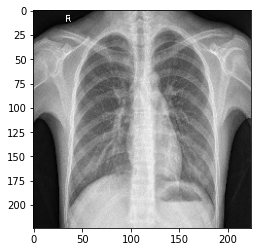

In [0]:
x_test= sample_test_image
plt.imshow(x_test[12])
plt.show()

In [0]:
#predictions=model.predict(x_test)
predictions=model.predict(test_data)

In [0]:
predictions.shape

(624, 1)

In [0]:
#predictions.shape
#print(np.round(predictions[12]))

(64, 1)

In [0]:
y_test = predictions > 0.5

In [0]:
y_test.shape

(624, 1)

In [0]:
cm1  = confusion_matrix(test_labels1, y_test)

In [0]:
cm1

array([[126, 108],
       [ 26, 364]])

In [0]:
cm2  = confusion_matrix(test_labels2, y_test)

In [0]:
cm2

array([[ 26, 364],
       [126, 108]])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [0]:
#prediction = model.predict_generator(test_generator)

In [0]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2

from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
from pathlib import Path
data_dir = Path('/content/drive/My Drive/chest_xray')
test_dir = data_dir / 'test'

In [0]:
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [0]:
test_labels1 = test_labels[:,1:2]
test_labels2 = test_labels[:,0:1]
#test_labels1.shape

In [0]:
#model.evaluate(test_data, test_labels)
#print("Loss on test set: ", test_loss)
#print("Accuracy on test set: ", test_score)

In [0]:
"""preds = model.predict(test_data)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)"""

(624,)
(624,)


In [0]:
"""cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()"""

"plt.figure()\nplot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)\nplt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)\nplt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)\nplt.show()"

In [0]:
#cm

array([[234,   0],
       [390,   0]])

In [0]:

for layer in base_model.layers:
    layer.trainable = True

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['binary_accuracy'])

In [0]:
# Fit model
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = valid_generator,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = 10)
#, callbacks = [checkpoint]


**Visualize Accuracy and loss as training progresses.**

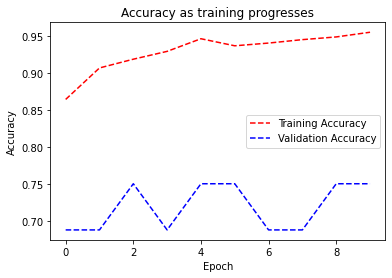

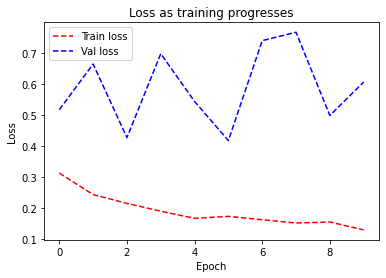

In [0]:
fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy as training progresses')
plt.plot(history.history['binary_accuracy'],'r--', label = "Training Accuracy" , linewidth=1.5)
plt.plot(history.history['val_binary_accuracy'], 'b--', label = "Validation Accuracy",  linewidth=1.5)
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Loss', title='Loss as training progresses')
plt.plot(history.history['loss'], 'r--', label = "Train loss", linewidth=1.5)
plt.plot(history.history['val_loss'], 'b--', label = "Val loss", linewidth=1.5)
plt.legend()
plt.show()


In [0]:
sample_test_image, label1= next(test_generator)

In [0]:
x_test= sample_test_image
plt.imshow(x_test[0])
plt.show()

NameError: ignored

In [0]:
predictions=model.predict(x_test)
print(np.round(predictions[0]))

NameError: ignored